<a id='Top'></a>

# Prepare clinical data <a class='tocSkip'></a>

Preprocess clinical data for all patients, collect relevant survival labels and define train/validation/test split using the unique patient ID codes.

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext watermark

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from lifelines import KaplanMeierFitter

In [2]:
DATA_LOCATION = '/mnt/data/Processed_Data/Clinical'

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-and-explore-data" data-toc-modified-id="Load-and-explore-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load and explore data</a></span></li><li><span><a href="#Select-variables" data-toc-modified-id="Select-variables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Select variables</a></span></li><li><span><a href="#Clean-up-inconsistencies" data-toc-modified-id="Clean-up-inconsistencies-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Clean up inconsistencies</a></span><ul class="toc-item"><li><span><a href="#Consolidate-race-and-ethnicity" data-toc-modified-id="Consolidate-race-and-ethnicity-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Consolidate <code>race</code> and <code>ethnicity</code></a></span></li><li><span><a href="#Missing-label-data" data-toc-modified-id="Missing-label-data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Missing label data</a></span><ul class="toc-item"><li><span><a href="#vital_status" data-toc-modified-id="vital_status-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span><code>vital_status</code></a></span></li><li><span><a href="#Both-duration-values" data-toc-modified-id="Both-duration-values-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Both duration values</a></span></li><li><span><a href="#Required-duration-value" data-toc-modified-id="Required-duration-value-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Required duration value</a></span></li></ul></li><li><span><a href="#Not-missing-days_to_last_follow_up-when-vital_status-is-&quot;Dead&quot;" data-toc-modified-id="Not-missing-days_to_last_follow_up-when-vital_status-is-&quot;Dead&quot;-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Not missing <code>days_to_last_follow_up</code> when <code>vital_status</code> is "Dead"</a></span></li><li><span><a href="#Negative-durations" data-toc-modified-id="Negative-durations-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Negative durations</a></span></li></ul></li><li><span><a href="#Label-data" data-toc-modified-id="Label-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Label data</a></span></li><li><span><a href="#Train-val-test-split" data-toc-modified-id="Train-val-test-split-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train-val-test split</a></span><ul class="toc-item"><li><span><a href="#Survival-curves" data-toc-modified-id="Survival-curves-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Survival curves</a></span></li></ul></li><li><span><a href="#Save-clinical-data-to-file" data-toc-modified-id="Save-clinical-data-to-file-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Save clinical data to file</a></span></li><li><span><a href="#Input-missing-values" data-toc-modified-id="Input-missing-values-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Input missing values</a></span></li><li><span><a href="#Scale-continuous-variables" data-toc-modified-id="Scale-continuous-variables-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Scale continuous variables</a></span></li><li><span><a href="#Encode-categorical-variables" data-toc-modified-id="Encode-categorical-variables-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Encode categorical variables</a></span></li><li><span><a href="#Save-patient-data-to-files" data-toc-modified-id="Save-patient-data-to-files-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Save patient data to files</a></span><ul class="toc-item"><li><span><a href="#Survival-labels" data-toc-modified-id="Survival-labels-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>Survival labels</a></span></li><li><span><a href="#Clinical-data" data-toc-modified-id="Clinical-data-10.2"><span class="toc-item-num">10.2&nbsp;&nbsp;</span>Clinical data</a></span></li></ul></li></ul></div>

# Load and explore data

General exploration of data to remove features:
    * missing all data
    * with as many levels as there are patients

In [3]:
clinical = pd.read_csv('/mnt/data/RawData/clinical_data.tsv',
                       sep='\t', na_values=['not reported', 'Not Reported'],
                       low_memory=False)

In [4]:
clinical.shape

(11228, 223)

In [5]:
clinical.head(3)

,project,submitter_id,synchronous_malignancy,ajcc_pathologic_stage,days_to_diagnosis,laterality,created_datetime,last_known_disease_status,tissue_or_organ_of_origin,age_at_diagnosis,...,gleason_grade_tertiary,gleason_score,population_group,treatments_pharmaceutical_reason_treatment_ended,treatments_radiation_reason_treatment_ended,ajcc_serum_tumor_markers,treatments_pharmaceutical_pretreatment,treatments_pharmaceutical_radiosensitizing_agent,treatments_radiation_pretreatment,treatments_radiation_radiosensitizing_agent
0,TCGA-BRCA,TCGA-A7-A0DC,No,Stage IA,0.0,NaN,NaN,NaN,"Breast, NOS",23294.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TCGA-BRCA,TCGA-Z7-A8R6,No,Stage I,0.0,Left,NaN,NaN,Overlapping lesion of breast,16955.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TCGA-BRCA,TCGA-C8-A1HE,No,Stage IIA,0.0,Right,NaN,NaN,"Breast, NOS",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print('~~ MISSING DATA ~~')
print()

n = clinical.shape[0]

for col in clinical.columns:
    if col == 'submitter_id':
        continue

    n_levels = len(clinical[col].value_counts())
    
    if n_levels == n:
        clinical = clinical.drop(columns=[col])
    else:
        n_missing = sum(clinical[col].isnull())
        if n_missing > 0:
            if n_missing == n:
                clinical = clinical.drop(columns=[col])
            else:
                print(f'{col}: {n_missing} ({round(n_missing / n * 100, 2)}%)')

~~ MISSING DATA ~~

synchronous_malignancy: 1334 (11.88%)
ajcc_pathologic_stage: 4248 (37.83%)
days_to_diagnosis: 260 (2.32%)
laterality: 5567 (49.58%)
created_datetime: 11087 (98.74%)
tissue_or_organ_of_origin: 132 (1.18%)
age_at_diagnosis: 347 (3.09%)
primary_diagnosis: 148 (1.32%)
updated_datetime: 127 (1.13%)
prior_malignancy: 1338 (11.92%)
year_of_diagnosis: 281 (2.5%)
state: 127 (1.13%)
prior_treatment: 156 (1.39%)
diagnosis_is_primary_disease: 135 (1.2%)
method_of_diagnosis: 6377 (56.8%)
ajcc_staging_system_edition: 4672 (41.61%)
ajcc_pathologic_t: 3316 (29.53%)
morphology: 148 (1.32%)
ajcc_pathologic_n: 3377 (30.08%)
ajcc_pathologic_m: 4157 (37.02%)
classification_of_tumor: 364 (3.24%)
diagnosis_id: 127 (1.13%)
icd_10_code: 504 (4.49%)
site_of_resection_or_biopsy: 484 (4.31%)
tumor_grade: 6582 (58.62%)
metastasis_at_diagnosis: 10586 (94.28%)
figo_stage: 9749 (86.83%)
figo_staging_edition_year: 10403 (92.65%)
cigarettes_per_day: 11226 (99.98%)
exposure_id: 7519 (66.97%)
race: 10

In [7]:
clinical.shape

(11228, 136)

# Select variables

Select a few variables to keep and drop the remaining ones.

In [8]:
clinical.columns

Index(['project', 'submitter_id', 'synchronous_malignancy',
       'ajcc_pathologic_stage', 'days_to_diagnosis', 'laterality',
       'created_datetime', 'tissue_or_organ_of_origin', 'age_at_diagnosis',
       'primary_diagnosis',
       ...
       'cause_of_death_source', 'first_symptom_longest_duration',
       'melanoma_known_primary', 'gleason_grade_tertiary', 'gleason_score',
       'population_group', 'treatments_pharmaceutical_reason_treatment_ended',
       'ajcc_serum_tumor_markers', 'treatments_radiation_pretreatment',
       'treatments_radiation_radiosensitizing_agent'],
      dtype='object', length=136)

In [9]:
label_cols = ['submitter_id', 'days_to_last_follow_up', 'vital_status', 'days_to_death']

keep_cols = ['ajcc_pathologic_stage', 'age_at_diagnosis', 'prior_treatment', 'prior_malignancy',
             'synchronous_malignancy', 'gender', 'race', 'ethnicity', 'disease',
             'treatments_pharmaceutical_treatment_or_therapy',
             'treatments_radiation_treatment_or_therapy']

columns_to_drop = [col for col in clinical.columns if col not in label_cols + keep_cols]
clinical = clinical.drop(columns=columns_to_drop)

In [10]:
print('~~ MISSING DATA ~~')
print()

n = clinical.shape[0]

for v in clinical.columns:
    n_missing = sum(clinical[v].isnull())
    if n_missing > 0:
        if n_missing == n:
            clinical = clinical.drop(columns=[v])
        else:
            print(f'{v}: {n_missing} ({round(n_missing / n * 100, 2)}%)')

~~ MISSING DATA ~~

synchronous_malignancy: 1334 (11.88%)
ajcc_pathologic_stage: 4248 (37.83%)
age_at_diagnosis: 347 (3.09%)
prior_malignancy: 1338 (11.92%)
prior_treatment: 156 (1.39%)
race: 1005 (8.95%)
gender: 136 (1.21%)
ethnicity: 2293 (20.42%)
vital_status: 156 (1.39%)
days_to_death: 7733 (68.87%)
days_to_last_follow_up: 192 (1.71%)
treatments_pharmaceutical_treatment_or_therapy: 5085 (45.29%)
treatments_radiation_treatment_or_therapy: 1305 (11.62%)


In [11]:
clinical.shape

(11228, 15)

In [12]:
clinical.columns

Index(['submitter_id', 'synchronous_malignancy', 'ajcc_pathologic_stage',
       'age_at_diagnosis', 'prior_malignancy', 'prior_treatment', 'race',
       'gender', 'ethnicity', 'vital_status', 'days_to_death',
       'days_to_last_follow_up',
       'treatments_pharmaceutical_treatment_or_therapy',
       'treatments_radiation_treatment_or_therapy', 'disease'],
      dtype='object')

In [13]:
clinical['gender'].value_counts()

gender
female    5726
male      5366
Name: count, dtype: int64

In [14]:
clinical['race'].value_counts()

race
white                                        8380
black or african american                     970
asian                                         683
Unknown                                       149
american indian or alaska native               28
native hawaiian or other pacific islander      13
Name: count, dtype: int64

In [15]:
clinical['ethnicity'].value_counts()

ethnicity
not hispanic or latino    8297
hispanic or latino         398
Unknown                    240
Name: count, dtype: int64

In [16]:
clinical['prior_malignancy'].value_counts()

prior_malignancy
no     9096
yes     794
Name: count, dtype: int64

In [17]:
clinical['vital_status'].value_counts()

vital_status
Alive      7549
Dead       3521
Unknown       2
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

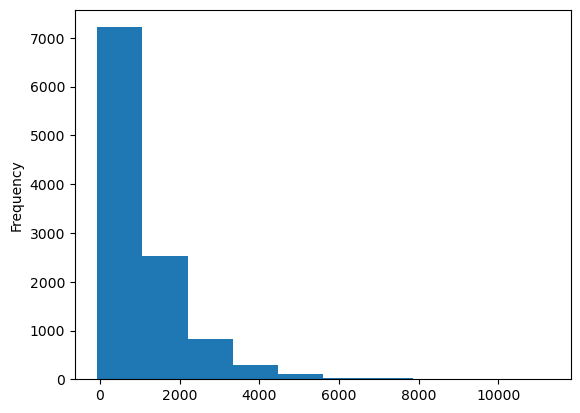

In [18]:
clinical['days_to_last_follow_up'].plot(kind='hist')

<Axes: >

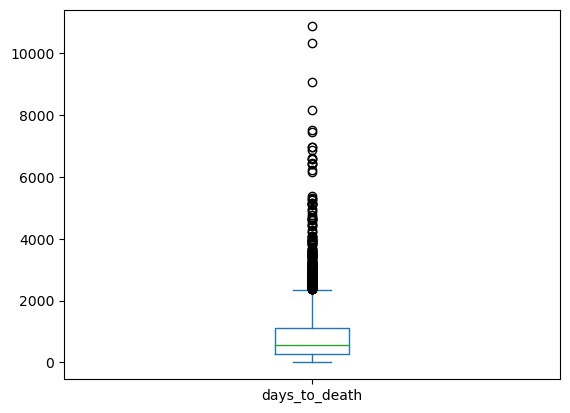

In [19]:
clinical['days_to_death'].plot(kind='box')

<Axes: >

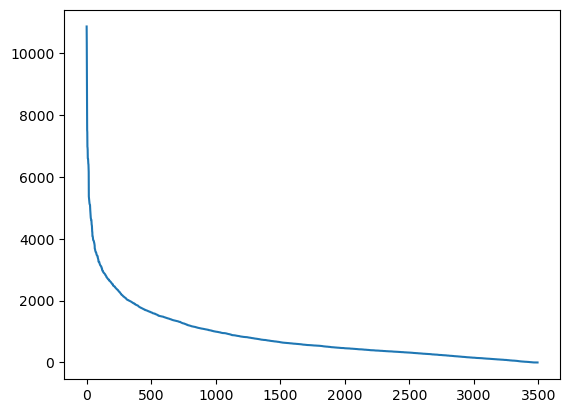

In [20]:
clinical['days_to_death'].sort_values(ascending=False).plot(use_index=False)

<Axes: >

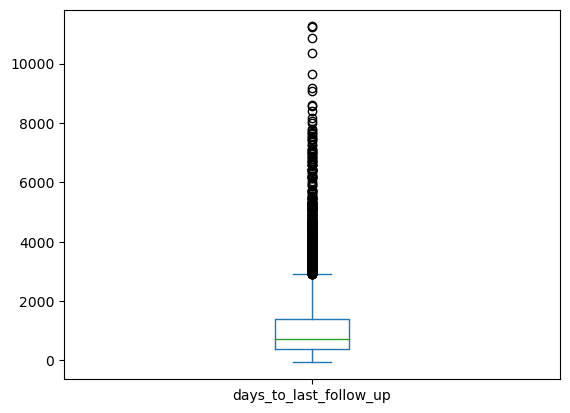

In [21]:
clinical['days_to_last_follow_up'].plot(kind='box')

<Axes: >

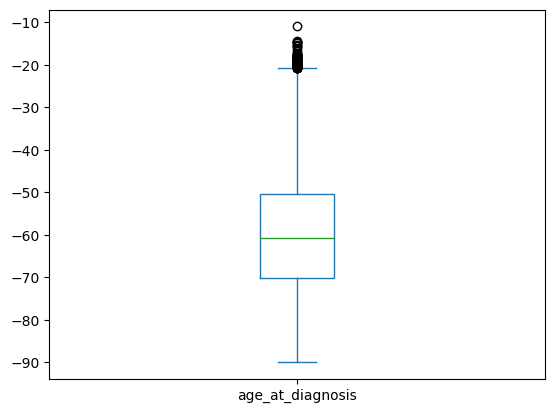

In [22]:
clinical['age_at_diagnosis'].apply(lambda x: -x/365).plot(kind='box')

<Axes: >

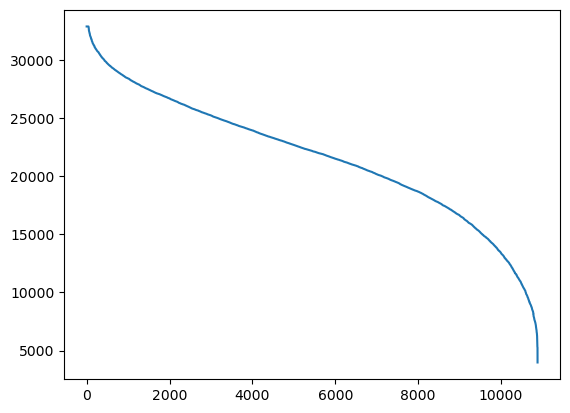

In [23]:
clinical['age_at_diagnosis'].sort_values(ascending=False).plot(use_index=False)

In [24]:
clinical.describe()

,age_at_diagnosis,days_to_death,days_to_last_follow_up
count,10881.000000,3495.000000,11036.000000
mean,21683.247312,862.220029,1058.199438
std,5327.403192,953.391165,1069.592704
min,3982.000000,0.000000,-64.000000
25%,18383.000000,282.000000,385.000000
50%,22173.000000,556.000000,726.000000
75%,25592.000000,1111.000000,1395.000000
max,32872.000000,10870.000000,11252.000000


In [25]:
clinical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11228 entries, 0 to 11227
Data columns (total 15 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   submitter_id                                    11228 non-null  object 
 1   synchronous_malignancy                          9894 non-null   object 
 2   ajcc_pathologic_stage                           6980 non-null   object 
 3   age_at_diagnosis                                10881 non-null  float64
 4   prior_malignancy                                9890 non-null   object 
 5   prior_treatment                                 11072 non-null  object 
 6   race                                            10223 non-null  object 
 7   gender                                          11092 non-null  object 
 8   ethnicity                                       8935 non-null   object 
 9   vital_status                           

Rename `disease` column as `project_id` and set it as table index.

In [26]:
clinical = clinical.rename(columns={'disease': 'project_id'})

In [27]:
clinical = clinical.set_index('submitter_id')

# Clean up inconsistencies

## Consolidate `race` and `ethnicity`

Whenever `race` value is "white" or missing replace it by `ethnicity` value (if present). Then drop ethnicity column.

In [28]:
race_subset = clinical['race'].isnull()
ethnicity_subset = ~clinical['ethnicity'].isnull()
subset = race_subset & ethnicity_subset
clinical.loc[subset, 'race'] = clinical.loc[subset, 'ethnicity']

In [29]:
race_subset = (clinical['race'] == 'white')
ethnicity_subset = (~clinical['ethnicity'].isnull() &
                    (clinical['ethnicity'] == 'hispanic or latino'))
subset = race_subset & ethnicity_subset
clinical.loc[subset, 'race'] = clinical.loc[subset, 'ethnicity']

In [30]:
clinical.loc[clinical['race'] == 'white', ].shape

(8059, 14)

In [31]:
clinical = clinical.drop('ethnicity', axis=1)

## Missing label data

The data show some inconsistencies, such as patients missing `vital_status` information, showing negative `days_to_last_follow_up` values, or missing `days_to_death` values. This is addressed in a few discussions under GitHub issues. [In one of them](https://github.com/BioinformaticsFMRP/TCGAbiolinks/issues/324) someone asked and got the following explanation from the GDC:

> "I have talked to our Clinical Data Scientist and she said that these values can seem strange due to how TCGA and third parties handled patient data. For the negative follow up dates, this can be caused by the pathology report being made at a secondary institution that does the surgery, even though the patient was diagnosed at a local hospital. The larger institution/center eventually reports back the pathologic findings from the surgery, but they never receive follow-up information about the patient. Thus, the days to diagnosis would have been the date the pathology report was signed out, which is always day 0, but the last time the patient was seen relative to that date could have been days or weeks prior to that report being signed out. Basically, we are aware that these negative dates exist, and they are caused by pathology report dates taking priority as day 0. For the patients without days_to_death, this is the case that they knew the patient was deceased, but they were uncertain of the exact date. Thus, when filling out the clinical information they left this intentionally blank.."

Here, I will simply drop these patients from data. I did manually check on the online database the negative values, which matched my downloaded data.

### `vital_status`

In [32]:
print('~~ MISSING DATA ~~')
print()
skip = ['project_id', 'gender', 'race', 'ethnicity', 'prior_malignancy',
        'age_at_diagnosis', 'days_to_death', 'days_to_last_follow_up']

n = clinical.shape[0]

for v in clinical.columns:
    if v not in skip:
        n_missing = sum(clinical[v].isnull())
        print(f'{v}: {n_missing} ({round(n_missing / n * 100, 2)}%)')

~~ MISSING DATA ~~

synchronous_malignancy: 1334 (11.88%)
ajcc_pathologic_stage: 4248 (37.83%)
prior_treatment: 156 (1.39%)
vital_status: 156 (1.39%)
treatments_pharmaceutical_treatment_or_therapy: 5085 (45.29%)
treatments_radiation_treatment_or_therapy: 1305 (11.62%)


In [33]:
# Drop patients missing "vital_status" information
subset = ~clinical.vital_status.isna()
clinical = clinical.loc[subset]

### Both duration values

Patients missing both time to death and time to last follow up variables cannot be included in a survival study.

In [34]:
missing_duration_data = clinical[
    clinical['days_to_death'].isna() &
    clinical['days_to_last_follow_up'].isna()]

print('# patients missing both duration columns:', missing_duration_data.shape[0])

# patients missing both duration columns: 38


In [35]:
missing_duration_data.head()

,synchronous_malignancy,ajcc_pathologic_stage,age_at_diagnosis,prior_malignancy,prior_treatment,race,gender,vital_status,days_to_death,days_to_last_follow_up,treatments_pharmaceutical_treatment_or_therapy,treatments_radiation_treatment_or_therapy,project_id
submitter_id,,,,,,,,,,,,,
TCGA-A7-A0DC,No,Stage IA,23294.0,no,No,white,female,Alive,NaN,NaN,yes,yes,TCGA-BRCA
TCGA-AJ-A3BH,No,NaN,NaN,no,No,white,female,Alive,NaN,NaN,NaN,NaN,TCGA-UCEC
TCGA-KN-8430,No,Stage I,27467.0,yes,No,white,male,Dead,NaN,NaN,no,no,TCGA-KICH
TCGA-CQ-A4CA,No,Stage II,NaN,no,No,NaN,male,Alive,NaN,NaN,no,no,TCGA-HNSC
TCGA-A6-2670,No,Stage IIA,16512.0,no,No,white,male,Alive,NaN,NaN,no,no,TCGA-COAD


In [36]:
# Remove missing data
subset = ~(clinical['days_to_death'].isna() &
           clinical['days_to_last_follow_up'].isna())
clinical = clinical.loc[subset]

In [37]:
clinical.shape

(11034, 13)

### Required duration value

Patients alive at the end of the study require time to last follow up information. Dead patients require time to death information.

In [38]:
print('# patients missing "days_to_last_follow_up" when "vital_status" is "Alive":',
      clinical[(clinical.vital_status == 'Alive') &
               clinical.days_to_last_follow_up.isna()].shape[0])

# patients missing "days_to_last_follow_up" when "vital_status" is "Alive": 0


In [39]:
print('# patients missing "days_to_death" when "vital_status" is "Dead":',
      clinical[(clinical.vital_status == 'Dead') &
               clinical.days_to_death.isna()].shape[0])

# patients missing "days_to_death" when "vital_status" is "Dead": 15


In [40]:
# Remove missing data
subset = ~((clinical.vital_status == 'Dead') &
           clinical.days_to_death.isna())
clinical = clinical.loc[subset]

## Not missing `days_to_last_follow_up` when `vital_status` is "Dead"

In [41]:
print('"Days to death" variable missing for all patients still alive?',
      all(clinical[clinical.vital_status == 'Alive'].days_to_death.isna()))

"Days to death" variable missing for all patients still alive? True


In [42]:
print('"Days to last follow up" variable missing for all dead patients?',
      all(clinical[clinical.vital_status == 'Dead'].days_to_last_follow_up.isna()))

"Days to last follow up" variable missing for all dead patients? False


In [43]:
# Insert "NaN" in "days_to_last_follow_up" when "vital_status" is "Dead" 
subset = clinical.vital_status == 'Dead'
clinical.loc[subset, 'days_to_last_follow_up'] = None

In [44]:
print('"Days to last follow up" variable missing for all dead patients?',
      all(clinical[clinical.vital_status == 'Dead'].days_to_last_follow_up.isna()))

"Days to last follow up" variable missing for all dead patients? True


## Negative durations

In [45]:
clinical[clinical.days_to_last_follow_up < 0]

,synchronous_malignancy,ajcc_pathologic_stage,age_at_diagnosis,prior_malignancy,prior_treatment,race,gender,vital_status,days_to_death,days_to_last_follow_up,treatments_pharmaceutical_treatment_or_therapy,treatments_radiation_treatment_or_therapy,project_id
submitter_id,,,,,,,,,,,,,
TCGA-PL-A8LV,No,Stage IIIB,19746.0,no,No,black or african american,female,Alive,NaN,-7.0,unknown,unknown,TCGA-BRCA
TCGA-AX-A3FV,No,NaN,22752.0,no,No,white,female,Alive,NaN,-6.0,unknown;not reported,unknown,TCGA-UCEC
TCGA-CF-A9FH,No,Stage II,31236.0,no,No,asian,male,Alive,NaN,-64.0,no,no,TCGA-BLCA
TCGA-NQ-A638,No,Stage II,24410.0,no,No,white,male,Alive,NaN,-8.0,unknown,unknown,TCGA-MESO
TCGA-TQ-A7RS,No,NaN,9172.0,no,No,hispanic or latino,female,Alive,NaN,-1.0,no,no,TCGA-LGG
TCGA-EB-A430,No,Stage IIC,30344.0,no,No,white,male,Alive,NaN,-2.0,no,no,TCGA-SKCM


In [46]:
# Remove data
subset = ~((clinical.days_to_last_follow_up < 0) &
           (clinical.vital_status == 'Alive'))
clinical = clinical.loc[subset]

In [47]:
clinical.shape

(11013, 13)

# Label data

Collect duration label: `days_to_last_follow_up` and `days_to_death` for live and dead patients, respectively.

In [48]:
# First, let's identify which patients have issues
print("Checking for problematic patients...")

# Find patients with NaN or unexpected vital_status
valid_vital_status = ['Dead', 'Alive', '0', '1']
invalid_vital_mask = ~clinical['vital_status'].isin(valid_vital_status) | clinical['vital_status'].isna()
print(f"\nPatients with invalid vital_status: {invalid_vital_mask.sum()}")
if invalid_vital_mask.sum() > 0:
    print("Invalid vital_status values:", clinical[invalid_vital_mask]['vital_status'].unique())

# Find patients with missing follow-up info
missing_followup_mask = (
    (clinical['vital_status'].isin(['Dead', '1'])) & clinical['days_to_death'].isna()
) | (
    (clinical['vital_status'].isin(['Alive', '0'])) & clinical['days_to_last_follow_up'].isna()
)
print(f"Patients with missing follow-up data: {missing_followup_mask.sum()}")

# Combine all problematic cases
problematic_mask = invalid_vital_mask | missing_followup_mask
print(f"\nTotal problematic patients to remove: {problematic_mask.sum()}")
print(f"Percentage of data: {problematic_mask.sum() / len(clinical) * 100:.2f}%")

# Remove problematic patients
clinical = clinical[~problematic_mask].copy()

Checking for problematic patients...

Patients with invalid vital_status: 2
Invalid vital_status values: ['Unknown']
Patients with missing follow-up data: 0

Total problematic patients to remove: 2
Percentage of data: 0.02%


In [49]:
def get_duration(vital_status, days_to_death, days_to_last_follow_up):
    if vital_status == 'Dead':
        return days_to_death
    elif vital_status == 'Alive':
        return days_to_last_follow_up
    else:
        print('Found NaN in duration!')

def get_events(vital_status):
    if vital_status in ['1', 'Dead']:
        return 1
    elif vital_status in ['0', 'Alive']:
        return 0
    else:
        print('Found NaN in vital status!')

In [50]:
d = {'submitter_id': clinical.index,
     'time': clinical.apply(
         lambda x: get_duration(x['vital_status'], x['days_to_death'],
                                x['days_to_last_follow_up']), axis=1).values,
     'event': clinical.apply(
         lambda x: get_events(x['vital_status']), axis=1).values}

In [51]:
survival = pd.DataFrame.from_dict(d).astype(
    {'submitter_id': 'object', 'time': 'int64', 'event': 'int64'})

In [52]:
clinical = clinical.join(survival.set_index('submitter_id'))

In [53]:
clinical.head()

,synchronous_malignancy,ajcc_pathologic_stage,age_at_diagnosis,prior_malignancy,prior_treatment,race,gender,vital_status,days_to_death,days_to_last_follow_up,treatments_pharmaceutical_treatment_or_therapy,treatments_radiation_treatment_or_therapy,project_id,time,event
submitter_id,,,,,,,,,,,,,,,
TCGA-Z7-A8R6,No,Stage I,16955.0,no,No,white,female,Alive,NaN,3256.0,yes,no,TCGA-BRCA,3256,0
TCGA-C8-A1HE,No,Stage IIA,NaN,no,No,asian,female,Alive,NaN,375.0,yes,no,TCGA-BRCA,375,0
TCGA-A8-A07B,No,Stage IIA,25475.0,no,No,NaN,female,Alive,NaN,1308.0,no,no,TCGA-BRCA,1308,0
TCGA-AC-A2FM,No,Stage IIB,31805.0,no,No,white,female,Dead,792.0,NaN,no,no,TCGA-BRCA,792,1
TCGA-B6-A1KF,No,Stage IIB,24891.0,no,No,white,female,Alive,NaN,3088.0,yes,yes,TCGA-BRCA,3088,0


# Train-val-test split

Split by patient and stratify by `project_id`.

In [54]:
cases = list(clinical.index.unique())
cases[:3]

['TCGA-Z7-A8R6', 'TCGA-C8-A1HE', 'TCGA-A8-A07B']

In [55]:
from collections import Counter

def create_stratified_survival_splits(clinical_df, val_size=0.1, test_size=0.1, random_state=42):
    """
    Create stratified train/val/test splits that balance both project_id and event distributions.
    
    Args:
        clinical_df: DataFrame with clinical data
        val_size: Proportion for validation set (default 0.1)
        test_size: Proportion for test set (default 0.1) 
        random_state: Random seed for reproducibility
    
    Returns:
        clinical_df with added 'group' column
    """
    
    # Create a combined stratification variable from project_id and event
    clinical_df['stratify_var'] = clinical_df['project_id'].astype(str) + '_' + clinical_df['event'].astype(str)
    
    # Check if we have enough samples for each stratum
    stratum_counts = clinical_df['stratify_var'].value_counts()
    min_samples_needed = 2  # Minimum needed for stratification
    
    # Handle small strata by grouping them
    small_strata = stratum_counts[stratum_counts < min_samples_needed].index
    if len(small_strata) > 0:
        print(f"Warning: {len(small_strata)} strata have < {min_samples_needed} samples. Grouping by project_id only for these.")
        # For small strata, fall back to project_id only
        mask = clinical_df['stratify_var'].isin(small_strata)
        clinical_df.loc[mask, 'stratify_var'] = clinical_df.loc[mask, 'project_id'].astype(str) + '_mixed'
    
    X = clinical_df.drop(['stratify_var'], axis=1)
    y = clinical_df[['time']]
    stratify_col = clinical_df['stratify_var']
    
    # Stage 1: Split off validation set (10%)
    X_temp, X_val, y_temp, y_val, strat_temp, strat_val = train_test_split(
        X, y, stratify_col, 
        test_size=val_size, 
        random_state=random_state, 
        stratify=stratify_col
    )
    
    # Stage 2: Split remaining data into train and test
    # Calculate test_size for remaining data to get desired proportion of original
    remaining_test_size = test_size / (1 - val_size)
    
    X_train, X_test, y_train, y_test, strat_train, strat_test = train_test_split(
        X_temp, y_temp, strat_temp,
        test_size=remaining_test_size,
        random_state=random_state,
        stratify=strat_temp
    )
    
    # Create group assignment function
    def get_split_group(id_code):
        if id_code in X_train.index:
            return 'train'
        elif id_code in X_val.index:
            return 'val'
        elif id_code in X_test.index:
            return 'test'
        else:
            return 'missing'
    
    # Assign groups to original dataframe
    clinical_df['group'] = [get_split_group(x) for x in clinical_df.index]
    
    # Clean up temporary column
    clinical_df.drop('stratify_var', axis=1, inplace=True)
    
    return clinical_df, X_train, X_val, X_test

def validate_splits(clinical_df):
    """
    Validate that the splits maintain balanced distributions.
    """
    print("=== Split Distribution Analysis ===\n")
    
    # Overall split sizes
    split_counts = clinical_df['group'].value_counts()
    total_patients = len(clinical_df)
    
    print("Split sizes:")
    for group in ['train', 'val', 'test']:
        count = split_counts.get(group, 0)
        percentage = (count / total_patients) * 100
        print(f"  {group}: {count} patients ({percentage:.1f}%)")
    
    print("\n" + "="*50)
    
    # Event rate analysis by group
    print("\nEvent rates by group:")
    for group in ['train', 'val', 'test']:
        group_data = clinical_df[clinical_df['group'] == group]
        if len(group_data) > 0:
            event_rate = group_data['event'].mean()
            event_count = group_data['event'].sum()
            total_count = len(group_data)
            print(f"  {group}: {event_count}/{total_count} = {event_rate:.3f} ({event_rate*100:.1f}%)")
    
    print("\n" + "="*50)
    
    # Project distribution analysis
    print("\nProject distribution by group:")
    project_dist = pd.crosstab(clinical_df['project_id'], clinical_df['group'], normalize='columns')
    print(project_dist.round(3))
    
    print("\n" + "="*50)
    
    # Combined project + event analysis
    print("\nProject + Event distribution by group:")
    clinical_df['project_event'] = clinical_df['project_id'] + '_event_' + clinical_df['event'].astype(str)
    combined_dist = pd.crosstab(clinical_df['project_event'], clinical_df['group'], normalize='columns')
    print(combined_dist.round(3))
    
    # Clean up temporary column
    clinical_df.drop('project_event', axis=1, inplace=True)

In [56]:
# Create stratified splits
clinical, X_train, X_val, X_test = create_stratified_survival_splits(
    clinical, 
    val_size=0.1, 
    test_size=0.1, 
    random_state=42
)

In [57]:
clinical.head()

,synchronous_malignancy,ajcc_pathologic_stage,age_at_diagnosis,prior_malignancy,prior_treatment,race,gender,vital_status,days_to_death,days_to_last_follow_up,treatments_pharmaceutical_treatment_or_therapy,treatments_radiation_treatment_or_therapy,project_id,time,event,group
submitter_id,,,,,,,,,,,,,,,,
TCGA-Z7-A8R6,No,Stage I,16955.0,no,No,white,female,Alive,NaN,3256.0,yes,no,TCGA-BRCA,3256,0,train
TCGA-C8-A1HE,No,Stage IIA,NaN,no,No,asian,female,Alive,NaN,375.0,yes,no,TCGA-BRCA,375,0,train
TCGA-A8-A07B,No,Stage IIA,25475.0,no,No,NaN,female,Alive,NaN,1308.0,no,no,TCGA-BRCA,1308,0,train
TCGA-AC-A2FM,No,Stage IIB,31805.0,no,No,white,female,Dead,792.0,NaN,no,no,TCGA-BRCA,792,1,train
TCGA-B6-A1KF,No,Stage IIB,24891.0,no,No,white,female,Alive,NaN,3088.0,yes,yes,TCGA-BRCA,3088,0,train


In [58]:
# Convert duration to years
clinical['time'] = clinical['time'] / 365
clinical.head()

,synchronous_malignancy,ajcc_pathologic_stage,age_at_diagnosis,prior_malignancy,prior_treatment,race,gender,vital_status,days_to_death,days_to_last_follow_up,treatments_pharmaceutical_treatment_or_therapy,treatments_radiation_treatment_or_therapy,project_id,time,event,group
submitter_id,,,,,,,,,,,,,,,,
TCGA-Z7-A8R6,No,Stage I,16955.0,no,No,white,female,Alive,NaN,3256.0,yes,no,TCGA-BRCA,8.920548,0,train
TCGA-C8-A1HE,No,Stage IIA,NaN,no,No,asian,female,Alive,NaN,375.0,yes,no,TCGA-BRCA,1.027397,0,train
TCGA-A8-A07B,No,Stage IIA,25475.0,no,No,NaN,female,Alive,NaN,1308.0,no,no,TCGA-BRCA,3.583562,0,train
TCGA-AC-A2FM,No,Stage IIB,31805.0,no,No,white,female,Dead,792.0,NaN,no,no,TCGA-BRCA,2.169863,1,train
TCGA-B6-A1KF,No,Stage IIB,24891.0,no,No,white,female,Alive,NaN,3088.0,yes,yes,TCGA-BRCA,8.460274,0,train


In [59]:
def get_data_group(df, value='train'):
    group = df.loc[df['group'] == value]
    return group.drop(columns='group')

train = get_data_group(clinical, 'train')
val = get_data_group(clinical, 'val')
test = get_data_group(clinical, 'test')

In [60]:
print('# patients in split groups:')
print('     train:     ', len(train))
print('     validation:', len(val))
print('     test:      ', len(test))

# patients in split groups:
     train:      8808
     validation: 1102
     test:       1101


## Survival curves

Plot Kaplan-Meier survival function.

<Axes: title={'center': 'Training data'}, xlabel='Time (years)'>

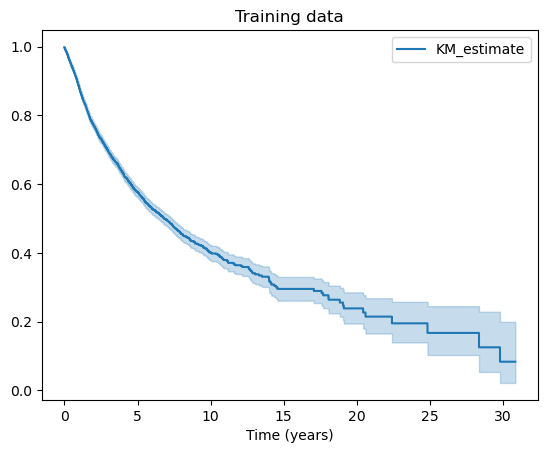

In [61]:
kmf = KaplanMeierFitter()
kmf.fit(train['time'], event_observed=train['event'])
ax = kmf.plot(title='Training data')
ax.set_xlabel('Time (years)')
ax

<Axes: title={'center': 'Validation data'}, xlabel='Time (years)'>

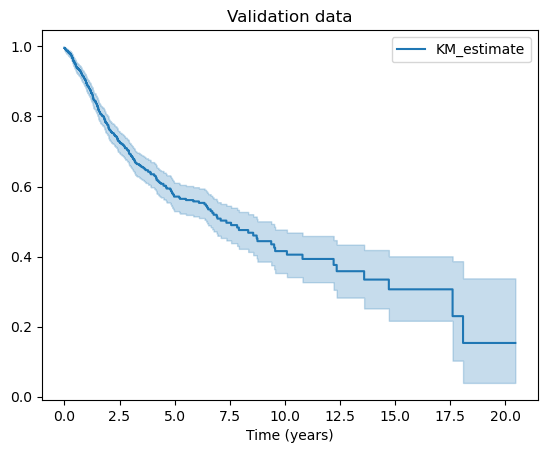

In [62]:
kmf = KaplanMeierFitter()
kmf.fit(val['time'], event_observed=val['event'])
ax = kmf.plot(title='Validation data')
ax.set_xlabel('Time (years)')
ax

<Axes: title={'center': 'Test data'}, xlabel='Time (years)'>

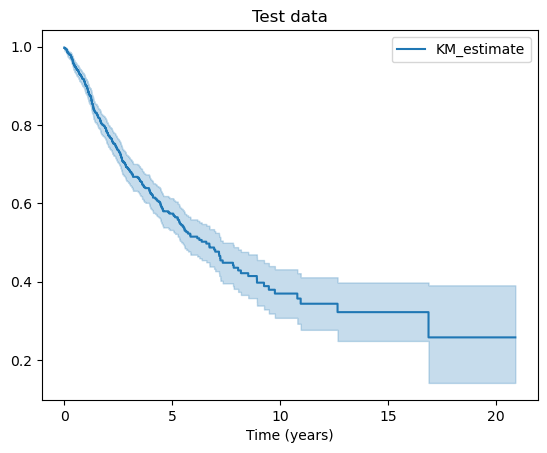

In [63]:
kmf = KaplanMeierFitter()
kmf.fit(test['time'], event_observed=test['event'])
ax = kmf.plot(title='Test data')
ax.set_xlabel('Time (years)')
ax

# Save clinical data to file

To use in the visualization of the features learned by the model.

In [64]:
clinical.head()

,synchronous_malignancy,ajcc_pathologic_stage,age_at_diagnosis,prior_malignancy,prior_treatment,race,gender,vital_status,days_to_death,days_to_last_follow_up,treatments_pharmaceutical_treatment_or_therapy,treatments_radiation_treatment_or_therapy,project_id,time,event,group
submitter_id,,,,,,,,,,,,,,,,
TCGA-Z7-A8R6,No,Stage I,16955.0,no,No,white,female,Alive,NaN,3256.0,yes,no,TCGA-BRCA,8.920548,0,train
TCGA-C8-A1HE,No,Stage IIA,NaN,no,No,asian,female,Alive,NaN,375.0,yes,no,TCGA-BRCA,1.027397,0,train
TCGA-A8-A07B,No,Stage IIA,25475.0,no,No,NaN,female,Alive,NaN,1308.0,no,no,TCGA-BRCA,3.583562,0,train
TCGA-AC-A2FM,No,Stage IIB,31805.0,no,No,white,female,Dead,792.0,NaN,no,no,TCGA-BRCA,2.169863,1,train
TCGA-B6-A1KF,No,Stage IIB,24891.0,no,No,white,female,Alive,NaN,3088.0,yes,yes,TCGA-BRCA,8.460274,0,train


In [65]:
clinical.to_csv('clinical_data.tsv', sep='\t')

# Input missing values

* Input missing continuous data with median value.
* Leave categorical features unchanged, to treat missing data as its own category.

In [66]:
print('~~ MISSING DATA ~~')
print()
skip = ['project_id', 'days_to_death', 'days_to_last_follow_up']

n = clinical.shape[0]

for v in clinical.columns:
    if v not in skip:
        n_missing = sum(clinical[v].isnull())
        if n_missing > 0:
            print(f'{v}: {n_missing} ({round(n_missing / n * 100, 2)}%)')

~~ MISSING DATA ~~

synchronous_malignancy: 1194 (10.84%)
ajcc_pathologic_stage: 4076 (37.02%)
age_at_diagnosis: 165 (1.5%)
prior_malignancy: 1182 (10.73%)
prior_treatment: 4 (0.04%)
race: 776 (7.05%)
treatments_pharmaceutical_treatment_or_therapy: 4910 (44.59%)
treatments_radiation_treatment_or_therapy: 1146 (10.41%)


In [67]:
def input_missing_values(feature, df):
    train_subset = df.loc[df['group'] == 'train', feature]
    try:
        input_value = train_subset.median()
        print(f'Median "{feature}": {input_value}')
    except TypeError:
        input_value = train_subset.mode().iloc[0]
        print(f'Mode "{feature}": {input_value}')

    df[feature].fillna(input_value, inplace=True)
    
    return df

In [68]:
clinical = input_missing_values(feature='age_at_diagnosis', df=clinical)

Median "age_at_diagnosis": 22197.0


In [69]:
print('~~ MISSING DATA ~~')
print()
n = clinical.shape[0]

for v in clinical.columns:
    n_missing = sum(clinical[v].isnull())
    if n_missing > 0:
        print(f'{v}: {n_missing} ({round(n_missing / n * 100, 2)}%)')

~~ MISSING DATA ~~

synchronous_malignancy: 1194 (10.84%)
ajcc_pathologic_stage: 4076 (37.02%)
prior_malignancy: 1182 (10.73%)
prior_treatment: 4 (0.04%)
race: 776 (7.05%)
days_to_death: 7516 (68.26%)
days_to_last_follow_up: 3495 (31.74%)
treatments_pharmaceutical_treatment_or_therapy: 4910 (44.59%)
treatments_radiation_treatment_or_therapy: 1146 (10.41%)


# Scale continuous variables

In [70]:
id_groups = {
    'train': list(clinical.loc[clinical['group'] == 'train', ].index),
    'val': list(clinical.loc[clinical['group'] == 'val', ].index),
    'test': list(clinical.loc[clinical['group'] == 'test', ].index)}

In [71]:
clinical.columns

Index(['synchronous_malignancy', 'ajcc_pathologic_stage', 'age_at_diagnosis',
       'prior_malignancy', 'prior_treatment', 'race', 'gender', 'vital_status',
       'days_to_death', 'days_to_last_follow_up',
       'treatments_pharmaceutical_treatment_or_therapy',
       'treatments_radiation_treatment_or_therapy', 'project_id', 'time',
       'event', 'group'],
      dtype='object')

In [72]:
skip

['project_id', 'days_to_death', 'days_to_last_follow_up']

In [73]:
continuous = ['age_at_diagnosis']

In [74]:
def min_max_scale(data, features, groups):
    train = data.loc[data.index.isin(groups['train']), features]

    scaler = MinMaxScaler()
    columns = train.columns
    scaler = scaler.fit(train[columns])
    
    data.loc[data.index.isin(groups['train']), features] = scaler.transform(
        train)
    data.loc[data.index.isin(groups['val']), features] = scaler.transform(
        data.loc[data.index.isin(groups['val']), features])
    data.loc[data.index.isin(groups['test']), features] = scaler.transform(
        data.loc[data.index.isin(groups['test']), features])
    
    return data

In [75]:
clinical = min_max_scale(data=clinical, features=continuous, groups=id_groups)

In [76]:
clinical.age_at_diagnosis.describe()

count    11011.000000
mean         0.612741
std          0.182958
min          0.000000
25%          0.500727
50%          0.630495
75%          0.745362
max          1.000000
Name: age_at_diagnosis, dtype: float64

In [77]:
clinical.head()

,synchronous_malignancy,ajcc_pathologic_stage,age_at_diagnosis,prior_malignancy,prior_treatment,race,gender,vital_status,days_to_death,days_to_last_follow_up,treatments_pharmaceutical_treatment_or_therapy,treatments_radiation_treatment_or_therapy,project_id,time,event,group
submitter_id,,,,,,,,,,,,,,,,
TCGA-Z7-A8R6,No,Stage I,0.449048,no,No,white,female,Alive,NaN,3256.0,yes,no,TCGA-BRCA,8.920548,0,train
TCGA-C8-A1HE,No,Stage IIA,0.630495,no,No,asian,female,Alive,NaN,375.0,yes,no,TCGA-BRCA,1.027397,0,train
TCGA-A8-A07B,No,Stage IIA,0.743960,no,No,NaN,female,Alive,NaN,1308.0,no,no,TCGA-BRCA,3.583562,0,train
TCGA-AC-A2FM,No,Stage IIB,0.963067,no,No,white,female,Dead,792.0,NaN,no,no,TCGA-BRCA,2.169863,1,train
TCGA-B6-A1KF,No,Stage IIB,0.723745,no,No,white,female,Alive,NaN,3088.0,yes,yes,TCGA-BRCA,8.460274,0,train


# Encode categorical variables

Encode labels (with a value between 0 and n_classes-1) to use with categorical embeddings.

In [78]:
# Drop unnecessary columns
clinical = clinical.drop(columns=['days_to_death', 'days_to_last_follow_up', 'vital_status'])

In [79]:
clinical.columns

Index(['synchronous_malignancy', 'ajcc_pathologic_stage', 'age_at_diagnosis',
       'prior_malignancy', 'prior_treatment', 'race', 'gender',
       'treatments_pharmaceutical_treatment_or_therapy',
       'treatments_radiation_treatment_or_therapy', 'project_id', 'time',
       'event', 'group'],
      dtype='object')

In [80]:
skip = ['time', 'event', 'group']
skip

['time', 'event', 'group']

In [81]:
continuous

['age_at_diagnosis']

In [82]:
len(clinical.columns)

13

In [83]:
categorical = [col for col in clinical.columns if col not in skip + continuous]

len(skip) + len(continuous) + len(categorical)

13

In [84]:
for feat in categorical:
    print(f'{feat}: {len(clinical[feat].unique())}')

synchronous_malignancy: 3
ajcc_pathologic_stage: 21
prior_malignancy: 3
prior_treatment: 3
race: 9
gender: 2
treatments_pharmaceutical_treatment_or_therapy: 16
treatments_radiation_treatment_or_therapy: 10
project_id: 32


In [85]:
len(clinical.columns)

13

In [86]:
# Reorder columns
categorical = ['project_id',  'gender', 'race', 'prior_treatment', 'prior_malignancy', 'synchronous_malignancy',
               'treatments_pharmaceutical_treatment_or_therapy',
               'treatments_radiation_treatment_or_therapy',
               'ajcc_pathologic_stage']

clinical = clinical[categorical + continuous + skip]

In [87]:
len(clinical.columns)

13

In [88]:
# Save a copy of the table to allow inclusion of unencoded "project_id" in the labels table
survival = clinical.copy()

In [89]:
split_groups = ['train', 'val', 'test']

label_encoders = {}
for feature in categorical:
    clinical[feature] = clinical[feature].astype(str)
    label_encoders[feature] = LabelEncoder()
    label_encoders[feature].fit(
        clinical.loc[clinical['group'] == 'train', feature])

for group in split_groups:
    for feature in categorical:
        clinical.loc[
            clinical['group'] == group, feature] = label_encoders[feature].transform(
            clinical.loc[clinical['group'] == group, feature])

ValueError: y contains previously unseen labels: 'Stage IB1'

The embedding dimensions (in a list of two-tuples) are calculated in the next cell: number of unique values paired with the embedding dimension for each categorical feature.

The embedding size is determined according to the rule-of-thumb from the Fast.ai course.

In [ ]:
categorical_dims = [int(clinical[col].nunique()) for col in categorical]
embedding_dims = [(x, min(50, (x + 1) // 2)) for x in categorical_dims]

embedding_dims

print('Feature                                            Levels   Embedding dims')
print('-------                                            ------   --------------')
for i, feat in enumerate(categorical):
    print(feat, ' ' * (50 - len(feat)), embedding_dims[i][0],
          ' ' * (7 - len(str(embedding_dims[i][0]))), embedding_dims[i][1])

# Save patient data to files

## Survival labels

In [90]:
survival['submitter_id'] = survival.index
survival = survival.reset_index(drop=True)

label_columns = ['submitter_id', 'project_id', 'time', 'event', 'group']
survival = survival.loc[:, label_columns]

In [91]:
survival.head()

,submitter_id,project_id,time,event,group
0,TCGA-Z7-A8R6,TCGA-BRCA,8.920548,0,train
1,TCGA-C8-A1HE,TCGA-BRCA,1.027397,0,train
2,TCGA-A8-A07B,TCGA-BRCA,3.583562,0,train
3,TCGA-AC-A2FM,TCGA-BRCA,2.169863,1,train
4,TCGA-B6-A1KF,TCGA-BRCA,8.460274,0,train


In [92]:
survival.to_csv('/app/data/labels.tsv', sep='\t', index=False)

## Clinical data

Save preprocessed clinical data as individual patient files (to use with PyTorch dataset).

In [ ]:
skip

In [ ]:
clinical = clinical[categorical + continuous]

In [ ]:
clinical.head()

In [ ]:
def table_to_patient_files(table, dir_path, round_digits=4):
    n = len(table)
    
    i = 0

    for index, row in table.iterrows():
        print('\r' + f'Save data to files: {str(i + 1)}/{n}', end='')
        i+= 1

        target_file = os.path.join(dir_path, str(index) + '.tsv')
        
        with open(target_file, 'w') as f:
            if round_digits is not None:
                f.write('\n'.join(str(round(value, round_digits)) for value in row.values))
            else:
                f.write('\n'.join(str(value) for value in row.values))

    print()
    print()

# Watermark <a class='tocSkip'></a>

In [ ]:
%watermark --iversions
%watermark -v
print()
%watermark -u -n

[Top of the page](#Top)